In [17]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
customers = pd.read_csv('olist_customers_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')

In [3]:
#1 How many users do we have who have made only one purchase?
user_purchases = pd.merge(customers, orders, on='customer_id')
user_purchase_counts = user_purchases.groupby('customer_unique_id')['order_id'].nunique()
num_one_time_users = sum(user_purchase_counts == 1)
print(f"There are {num_one_time_users} users who have made only one purchase.")

There are 93099 users who have made only one purchase.


In [4]:
#2 How many orders per month on average are not delivered for various reasons (breakdown by reason)?
undelivered_orders = orders[orders['order_status'] != 'delivered']
undelivered_orders['month'] = pd.to_datetime(undelivered_orders['order_purchase_timestamp']).dt.to_period('M')
undelivered_reasons = undelivered_orders.groupby(['month', 'order_status'])['order_id'].count()
print(undelivered_reasons)

month    order_status
2016-09  canceled         2
         shipped          1
2016-10  canceled        24
         invoiced        18
         processing       2
                         ..
2018-08  shipped         47
         unavailable      7
2018-09  canceled        15
         shipped          1
2018-10  canceled         4
Name: order_id, Length: 113, dtype: int64


C:\Users\79262\AppData\Local\Temp\ipykernel_8100\1607988765.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  undelivered_orders['month'] = pd.to_datetime(undelivered_orders['order_purchase_timestamp']).dt.to_period('M')


In [5]:
#3 For each product, determine on which day of the week the product is most often purchased.
product_purchases = pd.merge(order_items, orders, on='order_id')
product_purchases['weekday'] = pd.to_datetime(product_purchases['order_purchase_timestamp']).dt.day_name()
popular_purchase_days = product_purchases.groupby('product_id')['weekday'].agg(lambda x: x.value_counts().index[0])
print(popular_purchase_days)

product_id
00066f42aeeb9f3007548bb9d3f33c38       Sunday
00088930e925c41fd95ebfe695fd2655      Tuesday
0009406fd7479715e4bef61dd91f2462     Thursday
000b8f95fcb9e0096488278317764d19       Friday
000d9be29b5207b54e86aa1b1ac54872      Tuesday
                                      ...    
fff6177642830a9a94a0f2cba5e476d1     Saturday
fff81cc3158d2725c0655ab9ba0f712c       Monday
fff9553ac224cec9d15d49f5a263411f       Friday
fffdb2d0ec8d6a61f0a0a0db3f25b441      Tuesday
fffe9eeff12fcbd74a2f2b007dde0c58    Wednesday
Name: weekday, Length: 32951, dtype: object


In [6]:
#4 How many purchases does each user have on average per week (by month)?
user_purchases['month'] = pd.to_datetime(user_purchases['order_purchase_timestamp']).dt.to_period('M')
user_purchases_per_week = user_purchases.groupby(['customer_unique_id', 'month'])['order_id'].nunique() / 4.28
average_purchases_per_week = user_purchases_per_week.groupby('customer_unique_id').mean()
print(average_purchases_per_week)

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2    0.233645
0000b849f77a49e4a4ce2b2a4ca5be3f    0.233645
0000f46a3911fa3c0805444483337064    0.233645
0000f6ccb0745a6a4b88665a16c9f078    0.233645
0004aac84e0df4da2b147fca70cf8255    0.233645
                                      ...   
fffcf5a5ff07b0908bd4e2dbc735a684    0.233645
fffea47cd6d3cc0a88bd621562a9d061    0.233645
ffff371b4d645b6ecea244b27531430a    0.233645
ffff5962728ec6157033ef9805bacc48    0.233645
ffffd2657e2aad2907e67c3e9daecbeb    0.233645
Name: order_id, Length: 96096, dtype: float64


In [7]:
#5 Using pandas, conduct a cohort analysis of users.
user_orders = pd.merge(customers, orders, on='customer_id')
user_orders['month'] = pd.to_datetime(user_orders['order_purchase_timestamp']).dt.to_period('M')
user_orders = user_orders[['customer_unique_id', 'month']]
user_orders['cohort_month'] = user_orders.groupby('customer_unique_id')['month'].transform('min')
user_orders['cohort_index'] = (user_orders['month'].dt.year - user_orders['cohort_month'].dt.year) * 12 + (user_orders['month'].dt.month - user_orders['cohort_month'].dt.month) + 1
cohorts = user_orders.groupby(['cohort_month', 'cohort_index'])['customer_unique_id'].nunique().reset_index()
cohort_counts = cohorts.pivot(index='cohort_month', columns='cohort_index', values='customer_unique_id')
retention = cohort_counts.divide(cohort_counts.iloc[:,0], axis=0).round(3) * 100
highest_retention_cohort = retention[retention.iloc[:, 2] == retention.iloc[:, 2].max()].index[0]
print(f"The highest retention cohort for the 3rd month is {highest_retention_cohort}.")

The highest retention cohort for the 3rd month is 2017-05.


In [27]:
#6 RFM
customers = pd.read_csv('olist_customers_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')


In [28]:
# Merge the datasets
data = pd.merge(customers, orders, on='customer_id')
data = pd.merge(data, order_items, on='order_id')

# Convert timestamp columns to datetime format
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'])
data['order_delivered_customer_date'] = pd.to_datetime(data['order_delivered_customer_date'])

# Calculate the monetary value for each order item
data['monetary'] = data['price'] + data['freight_value']

# Keep only the necessary columns
data = data[['customer_unique_id', 'order_purchase_timestamp', 'monetary']]


In [29]:
# Calculate the latest order date
latest_date = data['order_purchase_timestamp'].max()

# Calculate Recency, Frequency, and Monetary values for each customer
rfm = data.groupby('customer_unique_id').agg({'order_purchase_timestamp': lambda x: (latest_date - x.max()).days,
                                              'customer_unique_id': 'count',
                                              'monetary': 'sum'})

# Rename the columns
rfm.rename(columns={'order_purchase_timestamp': 'recency',
                     'customer_unique_id': 'frequency',
                     'monetary': 'monetary_value'}, inplace=True)


In [30]:
# Create quantiles for each RFM value
quantiles = rfm.quantile(q=[0.25,0.5,0.75])

# Define a function to create RFM segments
def rfm_segment(x, p, d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

# Create RFM segments
rfm['R'] = rfm['recency'].apply(rfm_segment, args=('recency',quantiles,))
rfm['F'] = rfm['frequency'].apply(rfm_segment, args=('frequency',quantiles,))
rfm['M'] = rfm['monetary_value'].apply(rfm_segment, args=('monetary_value',quantiles,))

# Concatenate the RFM values to create a single RFM segment
rfm['RFM_Segment'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)

# Calculate the RFM score
rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis=1)

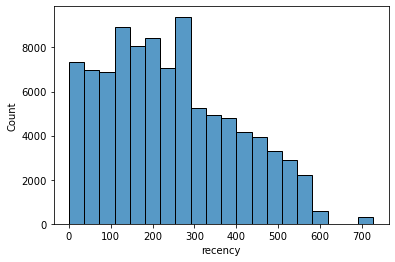

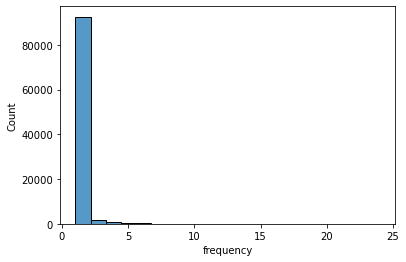

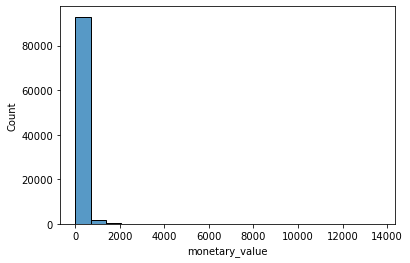

In [31]:
# Distribution of Recency
sns.histplot(rfm['recency'], kde=False, bins=20)
plt.show()

# Distribution of Frequency
sns.histplot(rfm['frequency'], kde=False, bins=20)
plt.show()

# Distribution of Monetary Value
sns.histplot(rfm['monetary_value'], kde=False, bins=20)
plt.show()


In [34]:
# Define function to build borders of recency, frequency, and monetary metrics for each segment
def build_segment_borders(segment):
    r = {
        '1': {'min': 0, 'max': quantiles['recency'][0.25]},
        '2': {'min': quantiles['recency'][0.25], 'max': quantiles['recency'][0.50]},
        '3': {'min': quantiles['recency'][0.50], 'max': quantiles['recency'][0.75]},
        '4': {'min': quantiles['recency'][0.75], 'max': rfm['recency'].max()}
    }
    
    f = {
        '1': {'min': rfm['frequency'].max() - 1, 'max': rfm['frequency'].max()},
        '2': {'min': quantiles['frequency'][0.75], 'max': rfm['frequency'].max() - 2},
        '3': {'min': quantiles['frequency'][0.50], 'max': quantiles['frequency'][0.75] - 1},
        '4': {'min': 0, 'max': quantiles['frequency'][0.50]}
    }
    
    m = {
        '1': {'min': quantiles['monetary_value'][0.75], 'max': rfm['monetary_value'].max()},
        '2': {'min': quantiles['monetary_value'][0.50], 'max': quantiles['monetary_value'][0.75]},
        '3': {'min': quantiles['monetary_value'][0.25], 'max': quantiles['monetary_value'][0.50]},
        '4': {'min': 0, 'max': quantiles['monetary_value'][0.25]}
    }
    
    return {
        'recency': {'min': r[segment[0]]['min'], 'max': r[segment[0]]['max']},
        'frequency': {'min': f[segment[1]]['min'], 'max': f[segment[1]]['max']},
        'monetary': {'min': m[segment[2]]['min'], 'max': m[segment[2]]['max']}
    }

# Build borders for each segment
for segment in rfm['RFM_Segment'].unique():
    borders = build_segment_borders(segment)
    print(f"RFM-segment {segment} (recency={segment[0]}, frequency={segment[1]}, monetary={segment[2]}) has borders of metrics "
          f"recency from {borders['recency']['min']:.0f} to {borders['recency']['max']:.0f} days, "
          f"frequency from {borders['frequency']['min']:.0f} to {borders['frequency']['max']:.0f} orders, "
          f"monetary from {borders['monetary']['min']:.0f} to {borders['monetary']['max']:.0f} monetary units.")


RFM-segment 442 (recency=4, frequency=4, monetary=2) has borders of metrics recency from 352 to 728 days, frequency from 0 to 1 orders, monetary from 108 to 183 monetary units.
RFM-segment 444 (recency=4, frequency=4, monetary=4) has borders of metrics recency from 352 to 728 days, frequency from 0 to 1 orders, monetary from 0 to 63 monetary units.
RFM-segment 143 (recency=1, frequency=4, monetary=3) has borders of metrics recency from 0 to 118 days, frequency from 0 to 1 orders, monetary from 63 to 108 monetary units.
RFM-segment 244 (recency=2, frequency=4, monetary=4) has borders of metrics recency from 118 to 223 days, frequency from 0 to 1 orders, monetary from 0 to 63 monetary units.
RFM-segment 241 (recency=2, frequency=4, monetary=1) has borders of metrics recency from 118 to 223 days, frequency from 0 to 1 orders, monetary from 183 to 13664 monetary units.
RFM-segment 342 (recency=3, frequency=4, monetary=2) has borders of metrics recency from 223 to 352 days, frequency from 0

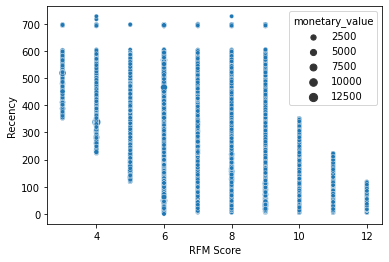

In [35]:
# Create a scatter plot with RFM score on the x-axis and recency on the y-axis
sns.scatterplot(x="RFM_Score", y="recency", data=rfm, size="monetary_value")

# Set the x-axis label
plt.xlabel("RFM Score")

# Set the y-axis label
plt.ylabel("Recency")

# Show the plot
plt.show()

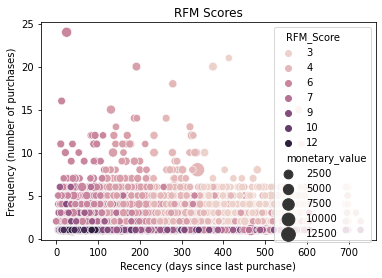

In [36]:
# Create a scatter plot of the RFM scores
sns.scatterplot(data=rfm, x='recency', y='frequency', hue='RFM_Score', size='monetary_value', sizes=(50, 200))

# Add labels and title
plt.xlabel('Recency (days since last purchase)')
plt.ylabel('Frequency (number of purchases)')
plt.title('RFM Scores')
plt.show()

  monetary_value         
F              1        4
R                        
1        172.300  167.525
2        176.900  161.875
3        166.125  162.525
4        176.825  166.400


<AxesSubplot:xlabel='None-F', ylabel='R'>

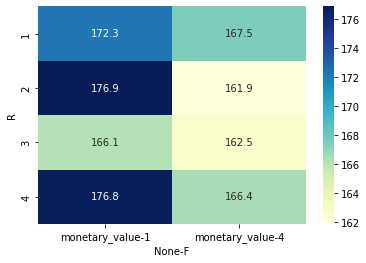

In [37]:
# Calculate the mean monetary value for each RFM score
rfm_table = rfm.groupby(['R', 'F', 'M']).agg({'monetary_value': 'mean'}).round(1)

# Pivot the table to create a matrix
rfm_matrix = rfm_table.pivot_table(index=['R'], columns=['F'], values=['monetary_value'], aggfunc='mean')

# Print the matrix
print(rfm_matrix)

# Visualize the matrix as a heatmap
sns.heatmap(rfm_matrix, annot=True, cmap='YlGnBu', fmt='.1f')